### Load modules

Firstly,let's load several modules needed.

In [37]:
import gensim
import os
import collections
import smart_open
import random
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
import scipy
import wordcloud
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-darkgrid')
%matplotlib inline
import pyLDAvis
pyLDAvis.enable_notebook()
import warnings
warnings.filterwarnings('ignore')

## First step first: Tokenize and clean Dataset

For a topic-central modelling problem like the one we're dealing with, the preprocessing is extremely important and requires a high meticulousness. There are tons of libraries outside to help us do a proper tokenization. I myself prefer `CountVectorizer` of `sklearn` due to its simplicity and versatile.

(Lot of people don't know module `CountVectorizer` is a very good `Tokenizer`)

In [38]:
class Vocab(CountVectorizer):
    def __init__(self, texts, **kwargs):
        super(Vocab, self).__init__(**kwargs)
        self.fit(texts)

    def __len__(self):
        return len(self.vocabulary_)
    
    def _to_bow(self, sent):
        analyzer = self.build_analyzer()
        seq = analyzer(sent)
        return [w for w in seq if w in self.vocabulary_]

    def _to_indices(self, sent):
        return [self.vocabulary_[w] for w in self._to_bow(sent)]
    
    def _build_dict(self):
        return {i: w for w, i in self.vocabulary_.items()}
    
    def _bow2id(self, sent):
        '''return pairs of (id, occurences) for each word in vocab
        '''
        mem = {}
        for i in self._to_indices(sent):
            if i not in mem:
                mem[i] = 1
            else:
                mem[i] += 1
        return [(i, o) for i, o in mem.items()]
                
                
def save_model(model, filename):
    print('saving model to %s ...' % filename)
    pickle.dump(model, open(filename, 'wb'))

def load_model(filename):
    print('loading model from %s ...' % filename)
    return pickle.load(open(filename, 'rb'))

# preprocessing func that tokenizes each doc and indexing it
def read_corpus(fname, vocab, tokens_only=False):
    with smart_open.smart_open(fname, encoding="iso-8859-1") as f:
        for i, line in enumerate(f):
            if tokens_only:
                yield vocab._to_bow(line) # use this func to tokenize a line
            else:
                # For training data, add tags
                yield gensim.models.doc2vec.TaggedDocument(vocab._to_bow(line), [i])
                
# in usual context, you can use `gensim.utils.simple_preprocess(line)`

In [39]:
# some carefully-thought params
vocab_size = 5000
kwargs = {'stop_words': 'english', 'max_df': 0.5, 'min_df': 2, 
          'max_features': vocab_size, 'strip_accents': 'unicode'}

In [40]:
# Set file names for train and test data
test_data_dir = '{}'.format(os.sep).join([gensim.__path__[0], 'test', 'test_data'])
lee_train_file = test_data_dir + os.sep + 'lee_background.cor'
lee_test_file = test_data_dir + os.sep + 'lee.cor'

In [41]:
train_texts = []
with smart_open.smart_open(lee_train_file, encoding="iso-8859-1") as f:
    for i, line in enumerate(f):
        train_texts.append(line)
        
vocab = Vocab(train_texts, **kwargs)

In [42]:
print(len(vocab.vocabulary_))

3380


In [43]:
# LDA with gensim
dct = gensim.corpora.Dictionary([vocab._to_bow(doc) for doc in train_texts])
corpus = [dct.doc2bow(vocab._to_bow(doc)) for doc in train_texts]
#dct = vocab._build_dict()
#corpus = [vocab._bow2id(doc) for doc in train_texts]
print(corpus[0])


[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 2), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 3), (40, 1), (41, 1), (42, 1), (43, 2), (44, 2), (45, 3), (46, 3), (47, 1), (48, 2), (49, 1), (50, 1), (51, 1), (52, 1), (53, 1), (54, 1), (55, 1), (56, 1), (57, 1), (58, 1), (59, 1), (60, 1), (61, 1), (62, 8), (63, 1), (64, 1), (65, 1), (66, 2), (67, 1), (68, 1), (69, 2), (70, 1), (71, 1), (72, 3), (73, 1), (74, 1), (75, 1), (76, 1), (77, 1), (78, 1), (79, 6), (80, 2), (81, 1), (82, 1), (83, 1), (84, 1), (85, 1), (86, 3), (87, 1), (88, 1), (89, 1), (90, 1), (91, 1), (92, 4), (93, 2), (94, 2), (95, 1), (96, 1), (97, 1)]


In [44]:
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = 10, id2word=dct, passes=20)
ldamodel.save('model10.gensim')
topics = ldamodel.print_topics(num_words=4)
for topic in topics:
    print(topic)

(0, '0.023*"mr" + 0.013*"palestinian" + 0.010*"israeli" + 0.009*"arafat"')
(1, '0.014*"government" + 0.009*"new" + 0.007*"security" + 0.007*"afghan"')
(2, '0.012*"workers" + 0.011*"australian" + 0.011*"qantas" + 0.010*"mr"')
(3, '0.022*"south" + 0.014*"new" + 0.012*"test" + 0.010*"sydney"')
(4, '0.016*"palestinian" + 0.011*"israeli" + 0.010*"mr" + 0.010*"hamas"')
(5, '0.019*"commission" + 0.014*"hih" + 0.010*"royal" + 0.010*"report"')
(6, '0.014*"mr" + 0.010*"world" + 0.010*"year" + 0.009*"australia"')
(7, '0.014*"palestinian" + 0.011*"police" + 0.011*"people" + 0.010*"arafat"')
(8, '0.018*"new" + 0.009*"people" + 0.009*"cent" + 0.007*"australian"')
(9, '0.016*"laden" + 0.016*"bin" + 0.014*"afghanistan" + 0.013*"al"')


In [45]:
print(ldamodel.get_topics().shape)

(10, 3380)


In [47]:
from pyLDAvis import gensim
lda_display = gensim.prepare(ldamodel, corpus, dct, sort_topics=False)
pyLDAvis.display(lda_display)

### Build-up dataset

The dataset is already included in the `gensim` module.

In [10]:
type(lee_train_file)
print(lee_train_file)

/home/redlcamille/anaconda3/lib/python3.6/site-packages/gensim/test/test_data/lee_background.cor


In [11]:
train_corpus = list(read_corpus(lee_train_file, vocab))
test_corpus = list(read_corpus(lee_test_file, vocab, tokens_only=True))

In [12]:
print(train_corpus[:2])

[TaggedDocument(words=['hundreds', 'people', 'forced', 'homes', 'southern', 'highlands', 'new', 'south', 'wales', 'strong', 'winds', 'today', 'pushed', 'huge', 'bushfire', 'town', 'hill', 'new', 'blaze', 'near', 'south', 'west', 'sydney', 'forced', 'closure', 'hume', 'highway', '00pm', 'aedt', 'marked', 'weather', 'storm', 'cell', 'moved', 'east', 'blue', 'mountains', 'forced', 'authorities', 'make', 'decision', 'evacuate', 'people', 'homes', 'streets', 'hill', 'new', 'south', 'wales', 'southern', 'highlands', 'estimated', '500', 'residents', 'left', 'homes', 'nearby', 'new', 'south', 'wales', 'rural', 'service', 'weather', 'conditions', 'caused', 'eased', '60', 'hill', 'optimistic', 'defending', 'properties', '100', 'blazes', 'new', 'year', 'eve', 'new', 'south', 'wales', 'crews', 'called', 'new', 'south', 'details', 'available', 'stage', 'authorities', 'closed', 'hume', 'highway', 'new', 'sydney', 'west', 'longer', 'threatening', 'properties', 'area', 'rain', 'fallen', 'parts', 'illa

### Build model along with its vocab

In [13]:
model = gensim.models.doc2vec.Doc2Vec(vector_size=50, min_count=2, epochs=40)

In [14]:
model.build_vocab(train_corpus)

In [15]:
%time model.train(train_corpus, total_examples=model.corpus_count, epochs=model.epochs)

CPU times: user 2.4 s, sys: 74.8 ms, total: 2.47 s
Wall time: 1.09 s


In [16]:
type(model.vocabulary.min_count)

int

In [17]:
vecs = model.wv.vectors
words = model.wv.index2word

In [18]:
print(vecs.shape)
n_topics = 5


(3380, 50)


In [19]:
from sklearn.mixture import GaussianMixture
def doGMM(X, nclust=5):
    model = GaussianMixture(n_components=nclust,init_params='kmeans')
    model.fit(X)
    cluster = model.predict(X)
    return model, cluster

In [20]:
clf, clus = doGMM(vecs[:,:2])

In [21]:
clus[5]

3

In [22]:
x = np.linspace(-2., 2., num=100)
y = np.linspace(-4., 1., num=70)
X, Y = np.meshgrid(x, y)
print(X.shape)
XX = np.array([X.ravel(), Y.ravel()]).T
Z = -clf.score_samples(XX)
Z = Z.reshape(X.shape)


(70, 100)


In [23]:
from matplotlib.colors import LogNorm

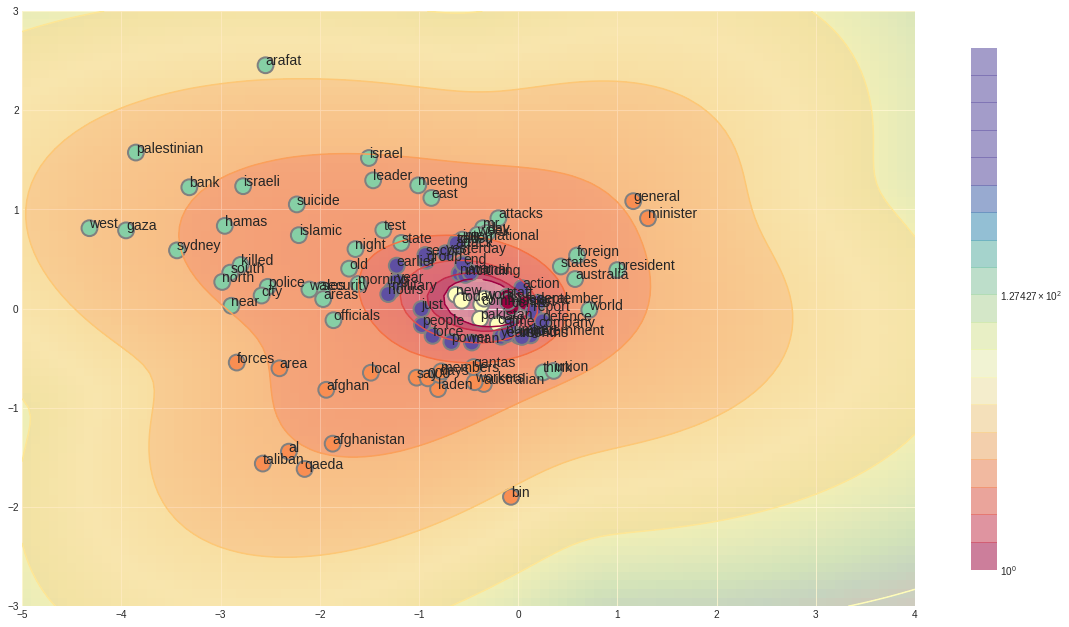

In [36]:
plt.figure(figsize=(20, 12))
sample_size = 100
axis = plt.gca()
np.set_printoptions(suppress=True)

CS = plt.contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=1000.0),
                 levels=np.logspace(0, 4, 20), cmap='Spectral', alpha=1)
#CB = plt.colorbar(CS, shrink=0.8, extend='both')
CF = plt.contourf(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=1000.0),
                 levels=np.logspace(0, 4, 20), cmap='Spectral', alpha=0.5)
CB = plt.colorbar(CF, shrink=0.8, extend='both')

plt.imshow(Z, extent=[-5, 4, -3, 3], origin='lower',
           cmap='Spectral', alpha=0.5)

plt.scatter(vecs[:sample_size, 0], vecs[:sample_size, 1], c=clus[:sample_size], marker=".", s=1000, 
            cmap="Spectral", alpha=1, edgecolors="grey", linewidth=2)

for idx in range(sample_size):
    plt.annotate(model.wv.index2word[idx],
                 xy=(vecs[idx, 0], vecs[idx, 1]),
                 xytext=(0, 0), textcoords='offset points', fontsize='14')
plt.savefig("tsne.png")
plt.show()

## Use cases

In [404]:
your_sen = 'australia attack'
ref_sen = ', australia is quite a tough one to live at'

In [405]:
vec = vocab._to_bow(your_sen)
vec_ = vocab._to_bow(ref_sen)
print(vec)
print(vec_)

['australia', 'attack']
['australia', 'quite', 'tough', 'live']


In [406]:
ranks = []
second_ranks = []
for doc_id in range(len(train_corpus)):
    inferred_vector = model.infer_vector(train_corpus[doc_id].words)
    sims = model.docvecs.most_similar([inferred_vector], topn=len(model.docvecs))
    rank = [docid for docid, sim in sims].index(doc_id)
    ranks.append(rank)
    
    second_ranks.append(sims[1])

In [407]:
rep = model.infer_vector(vec)
ref = model.infer_vector(vec_)

len(ref)

In [408]:
len(ref)

50

In [409]:
print(1-scipy.spatial.distance.cosine(rep, ref))

0.8943527936935425


In [410]:
wrdcld = wordcloud.WordCloud().generate(' '.join(vec))

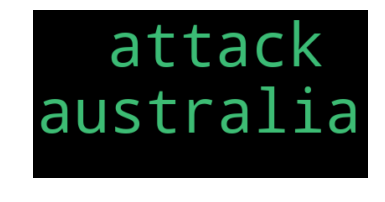

In [411]:
plt.imshow(wrdcld, interpolation='bilinear')
plt.axis("off")
plt.show()

In [412]:
def sort_relevant(subj, model, data, vocab, topn=5):
    rep = model.infer_vector(vocab._to_bow(subj))
    sims = model.docvecs.most_similar([rep], topn=topn)
    return sims

In [413]:
question = 'australian terrorist attack'
sims = sort_relevant(question, model, train_corpus, vocab)
for label, index in [('MOST', 0), ('SECOND-MOST', 1)]:
    print(u'%s %s: «%s»\n' % (label, sims[index], ' '.join(train_corpus[sims[index][0]].words)))

MOST (210, 0.7049915790557861): «australian government continuing indian authorities man confessed planning attacks australia countries year old mohammed afroz undertook pilot training australia 1997 1998 charged waging war india claims planning terrorist attacks australia towers melbourne target government taking claims seriously attorney general daryl williams claims simply accurate claim man relatives europe links osama bin laden terrorist network australia asking india permission man government sources say confirm request granted»

SECOND-MOST (217, 0.7039923667907715): «suspect allegedly involved planning terrorist attacks australia detained charged waging war india convicted 28 year old mohammed afroz faces hanging life imprisonment police say afroz arrested october staying hotel close home say afroz claimed osama bin laden al qaeda network planning terrorist attacks australia britain india similar september 11 attacks united states reportedly told police al qaeda suicide squads 

In [395]:
rep = model.infer_vector(gensim.utils.simple_preprocess(question))
word_sims = model.wv.most_similar([rep], topn=5)

In [396]:
print(word_sims)

[('confessed', 0.8196864724159241), ('planning', 0.7674869298934937), ('countries', 0.7382095456123352), ('man', 0.7282994985580444), ('india', 0.7190117239952087)]
